单词级别one-hot编码

In [1]:
import numpy as np

samples = ["The cat sat on the mat.", "The dog ate my homework"]
token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1

In [2]:
max_length = 10
results = np.zeros(shape=(len(samples), max_length, max(token_index.values()) + 1))

In [4]:
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

字符级别one-hot编码

In [5]:
import string
samples = ["The cat sat on the mat.", "The dog ate my homework."]
characters = string.printable
token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))

In [6]:
for i, sample in enumerate(samples):
    for j, character in enumerate(samples[:max_length]):
        index = token_index.get(character)
        results[i, j, index] = 1.

用keras实现单词级的one-hot编码

In [7]:
from keras.preprocessing.text import Tokenizer

samples = ["The cat sat on the mat.", "The dog ate my homework."]

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

Found 9 unique tokens.


使用散列技巧节省内存，并允许数据的在线编码，但会出现散列冲突(hash collision)的问题，即两个不同的单词可能具有相同的散列值。

In [9]:
samples = ["The cat sat on the mat.", "The dog ate my homework."]
dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

将一个embedding层实例化  
最好将Embedding层理解为一个字典，将整数索引(表特定单词)映射为密集向量。  
它接受整数作为输入，并在内部字典中查找这些整数，然后返回相关的向量。  
Embedding层实际上是一种字典查找。

Embedding层的输入是一个二维整数张量，其形状为(samples, sequence_length)，每个元素是一个整数序列。  
Embedding层可以嵌入长度可变的序列，不过一批数据中的所有序列必须具有相同的长度，所以较短的要用0填充，较长的序列应该被截断。  
这个Embedding层会返回一个形状为(samples, sequence_length, embedding_dimensionality)的三维浮点数张量。  
将一个Embedding层实例化后，它的权重最开始是随机的，在训练过程中利用反向传播来逐渐调节这些词向量，改变空间结构以便下游模型可以利用，一旦训练完成，嵌入空间将会展示大量结构，这种结构专门针对训练模型所要解决的问题。  

In [10]:
from keras.layers import Embedding
embedding_layer = Embedding(1000, 64)

# 加载IMDB数据，准备用于Embedding层

In [11]:
from keras.datasets import imdb
from keras import preprocessing

max_features = 10000
max_length = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_length)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_length)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/anaconda3/envs/nlp/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/anaconda3/envs/nlp/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

在IMDB数据上使用Embedding层和分类器

In [14]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=max_length))  # 将(20,10000)的one-hot向量展平为20*8
model.add(Flatten())  # 将三维的嵌入向量展平形状为(samples, maxlen * 8)的二维张量

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 2s 2ms/step - loss: 0.6864 - acc: 0.5572 - val_loss: 0.6244 - val_acc: 0.7010
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5735 - acc: 0.7469 - val_loss: 0.5270 - val_acc: 0.7272
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4688 - acc: 0.7900 - val_loss: 0.5008 - val_acc: 0.7448
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4213 - acc: 0.8123 - val_loss: 0.4927 - val_acc: 0.7556
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3887 - acc: 0.8260 - val_loss: 0.4930 - val_acc: 0.7578
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3705 - acc: 0.8396 - val_loss: 0.4955 - val_acc: 0.7606
Epoch 7/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3511 - acc: 0.8519 - val_loss: 0.5016 - val_acc: 0.7576
Epoch 8/10
625/625 [==============================] - 1s 2ms/step - loss: 0.

得到的精度约为75%，考虑到仅查看每条评论的前20个单词，这个结果还是相当不错的。  
但仅仅将嵌入序列展看并在上面训练一个Dense层，会导致模型对输入序列中的每个单词单独处理，而没有考虑单词之间的关系和句子结构。（例子：这个模型可能会将"this movie is a bomb"和"this movie is the bomb"都归类为负面评价，但后者为正面评价），更好的做法是在嵌入序列上添加循环层或一维卷积层，将每个序列作为整体来学习特征。

# 使用预训练但词嵌入

处理IMDB原始数据的标签

In [18]:
import os

imdb_dir = '/Users/chiang/Desktop/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

对数据进行分词

In [19]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [25]:
max_len = 100
training_samples = 200
validation_samples = 10000
max_word = 10000

tokenizer = Tokenizer(num_words=max_word)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("Found %s unique tokens" % len(word_index))

data = pad_sequences(sequences, maxlen=max_len)

labels = np.asarray(labels)
print("Shape of data tensor:", data.shape)
print("Shape of label tensor:", labels.shape)

# 打乱
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


解析GloVe词嵌入文件

In [26]:
glove_dir = "/Users/chiang/词向量/英文/Glove/glove.6B"

embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

print("Found %s word vectors." % len(embedding_index))

Found 400000 word vectors.


构建一个可以加载到Embedding层中的词嵌入矩阵，必须是一个形状为(max_words, embedding_dim)的矩阵。  
对于单词索引中索引为i的单词，这个矩阵的元素i就是这个单词对应的embedding_dim维向量。  
注意：索引0不应该代表任何的单词或标记，它只是一个占位符。

In [28]:
embedding_dim = 100

embedding_matrix = np.zeros((max_word, embedding_dim))
for word, i in word_index.items():
    if i < max_word:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  # 嵌入索引中找不到的词，其嵌入向量全为0

构建模型

In [31]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

In [32]:
model = Sequential()
model.add(Embedding(max_word, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


将预训练的词向量矩阵加载到Embedding层中

In [33]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [34]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 134ms/step - loss: 2.2955 - acc: 0.4931 - val_loss: 0.7216 - val_acc: 0.4972
Epoch 2/10
7/7 [==============================] - 1s 91ms/step - loss: 0.5512 - acc: 0.7581 - val_loss: 1.1223 - val_acc: 0.4985
Epoch 3/10
7/7 [==============================] - 1s 89ms/step - loss: 0.6215 - acc: 0.6830 - val_loss: 0.7458 - val_acc: 0.4928
Epoch 4/10
7/7 [==============================] - 1s 91ms/step - loss: 0.2902 - acc: 0.9203 - val_loss: 0.8522 - val_acc: 0.4967
Epoch 5/10
7/7 [==============================] - 1s 89ms/step - loss: 0.1307 - acc: 0.9963 - val_loss: 1.2644 - val_acc: 0.4982
Epoch 6/10
7/7 [==============================] - 1s 93ms/step - loss: 0.1326 - acc: 0.9626 - val_loss: 1.3046 - val_acc: 0.5027
Epoch 7/10
7/7 [==============================] - 1s 156ms/step - loss: 0.3896 - acc: 0.7933 - val_loss: 0.8290 - val_acc: 0.4965
Epoch 8/10
7/7 [==============================] - 1s 102ms/step - loss: 0.0437 - acc: 1.0000 - 

绘制结果

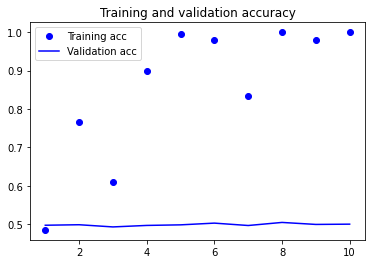

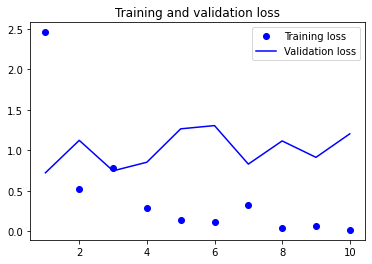

In [35]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

模型很快就过拟合了，考虑到训练样本很少，验证精度波动很大

## 在不使用预训练词向量下，训练相同模型

In [36]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

In [37]:
model = Sequential()
model.add(Embedding(max_word, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
7/7 [==============================] - 2s 170ms/step - loss: 0.6917 - acc: 0.5040 - val_loss: 0.6996 - val_acc: 0.5003
Epoch 2/10
7/7 [==============================] - 1s 113ms/step - loss: 0.4813 - acc: 0.9585 - val_loss: 0.7223 - val_acc: 0.5013
Epoch 3/10
7/7 [==============================] - 1s 113ms/step - loss: 0.2601 - acc: 0.9894 - val_loss: 0.7240 - val_acc: 0.5032
Epoch 4/10
7/7 [==============================] - 1s 111ms/step - loss: 0.1160 - acc: 1.0000 - val_loss: 0.7418 - val_acc: 0.5029
Epoch 5/10
7/7 [==============================] - 1s 150ms/step - loss: 0.0614 - acc: 1.0000 - val_loss: 0.8079 - val_acc: 0.5019
Epoch 6/10
7/7 [==============================] - 1s 182ms/step - loss: 0.0301 - acc: 1.0000 - val_loss: 0.7744 - val_acc: 0.4998
Epoch 7/10
7/7 [==============================] - 1s 141ms/step - loss: 0.0167 - acc: 1.0000 - val_loss: 0.7852 - val_acc: 0.5005
Epoch 8/10
7/7 [==============================] - 1s 147ms/step - loss: 0.0093 - acc: 1.00

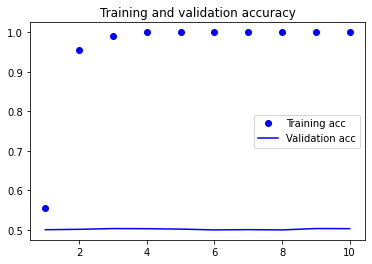

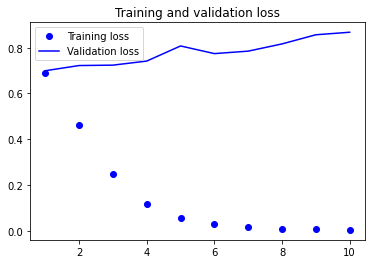

In [39]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

验证精度停留在50%多一点，因此词嵌入多性能要优于与任务一起学习的嵌入。

## 对测试集进行分词

In [40]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=max_len)
y_test = np.asarray(labels)

## 在测试集上评估模型

In [41]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 1.1983 - acc: 0.5026


[1.1982800960540771, 0.5026400089263916]

# 循环神经网络

## 简单RNN的numpy实现

In [5]:
import numpy as np

timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

In [6]:
successive_output = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    
    successive_output.append(output_t)
    
    state_t = output_t

final_output_sequence = np.stack(successive_output, axis=0)

## 准备IMDB数据

In [9]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500
batch_size = 32

print("Loading data...")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences(samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape', x_test.shape)

Loading data...


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/anaconda3/envs/nlp/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/anaconda3/envs/nlp/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

25000 train sequences
25000 test sequences
Pad sequences(samples x time)
x_train shape: (25000, 500)
x_test shape (25000, 500)


## 构建模型

In [10]:
from keras.layers import Dense, Embedding, SimpleRNN
from keras.models import Sequential

In [11]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [12]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 33s 204ms/step - loss: 0.6383 - acc: 0.6172 - val_loss: 0.4821 - val_acc: 0.7834
Epoch 2/10
157/157 [==============================] - 28s 176ms/step - loss: 0.3818 - acc: 0.8439 - val_loss: 0.3912 - val_acc: 0.8300
Epoch 3/10
157/157 [==============================] - 28s 178ms/step - loss: 0.2830 - acc: 0.8910 - val_loss: 0.3409 - val_acc: 0.8554
Epoch 4/10
157/157 [==============================] - 26s 168ms/step - loss: 0.2266 - acc: 0.9161 - val_loss: 0.4980 - val_acc: 0.8182
Epoch 5/10
157/157 [==============================] - 26s 165ms/step - loss: 0.1967 - acc: 0.9285 - val_loss: 0.3765 - val_acc: 0.8364
Epoch 6/10
157/157 [==============================] - 31s 195ms/step - loss: 0.1525 - acc: 0.9460 - val_loss: 0.3785 - val_acc: 0.8496
Epoch 7/10
157/157 [==============================] - 24s 156ms/step - loss: 0.1102 - acc: 0.9636 - val_loss: 0.5540 - val_acc: 0.7944
Epoch 8/10
157/157 [==============================] - 2

绘制结果

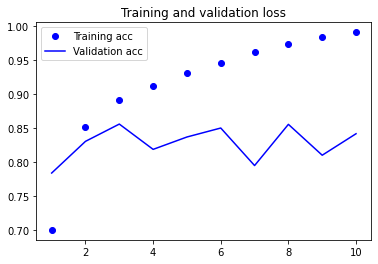

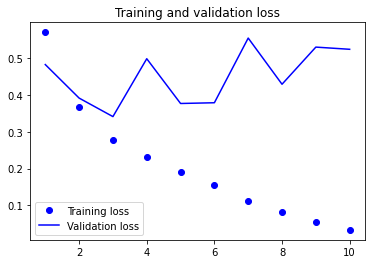

In [16]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc)+1)


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 使用Keras中的LSTM层

In [18]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 68s 423ms/step - loss: 0.6085 - acc: 0.6531 - val_loss: 0.3625 - val_acc: 0.8582
Epoch 2/10
157/157 [==============================] - 66s 419ms/step - loss: 0.3022 - acc: 0.8869 - val_loss: 0.3296 - val_acc: 0.8644
Epoch 3/10
157/157 [==============================] - 68s 431ms/step - loss: 0.2332 - acc: 0.9161 - val_loss: 0.3056 - val_acc: 0.8744
Epoch 4/10
157/157 [==============================] - 66s 420ms/step - loss: 0.1929 - acc: 0.9298 - val_loss: 0.2934 - val_acc: 0.8924
Epoch 5/10
157/157 [==============================] - 67s 429ms/step - loss: 0.1675 - acc: 0.9386 - val_loss: 0.4280 - val_acc: 0.8368
Epoch 6/10
157/157 [==============================] - 67s 424ms/step - loss: 0.1563 - acc: 0.9451 - val_loss: 0.3387 - val_acc: 0.8832
Epoch 7/10
157/157 [==============================] - 66s 420ms/step - loss: 0.1355 - acc: 0.9523 - val_loss: 0.3094 - val_acc: 0.8784
Epoch 8/10
157/157 [==============================] - 6

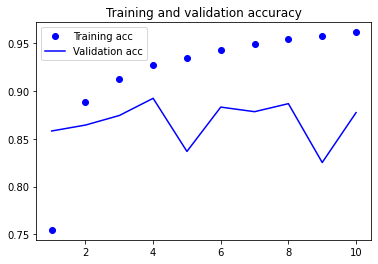

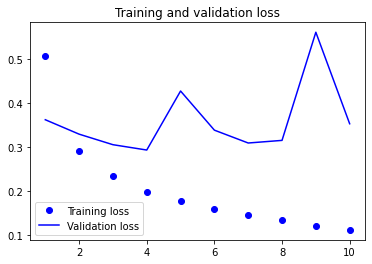

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()